In [25]:
import os, sys
import pandas as pd
from sctx.snvs.snvcmp import GroupBuilder, SampleData
import sctx.genotype as GT
import sctx.refine as RT
from sctx.find_snvs import FindSNVs

In [6]:
THREADS=12
sample = 'GSM4339778_SRR11182002'
annotated_snvs = 'GSM4339778_SRR11182002_annotated.h5'
groups = GroupBuilder(captured=False)
groups.add_group('g1000', 'Common', 'g1000')
groups.add_group('edit', 'A-to-G Edit', 'A_to_G_edit','~g1000')

TOTAL SNVs before filtering 83664
83664 24724 (83664, 8472)
Cutoffs discarded 58,940  / 83,664 SNVs [70.45%]


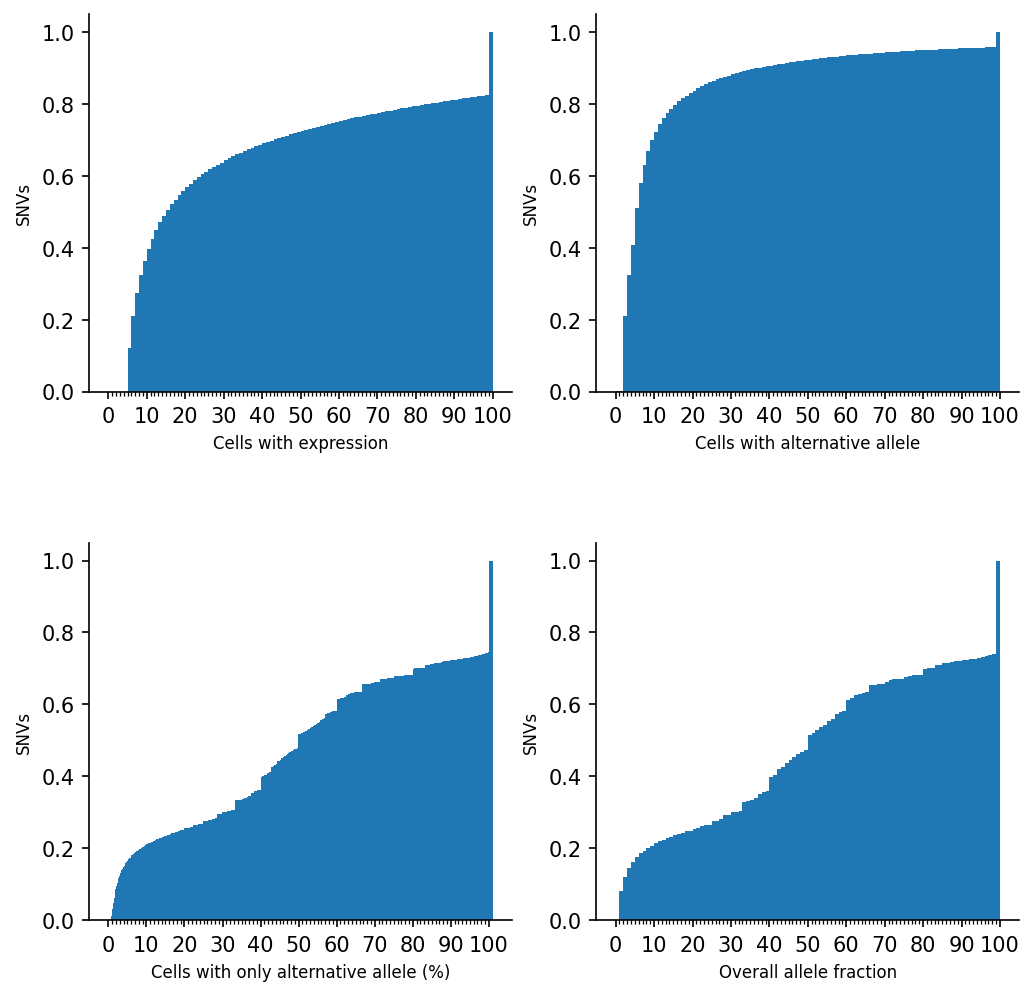

In [7]:
snv_data = SampleData(annotated_snvs, sample, groups=groups, load_matrix=True)
keep = (~snv_data.snvs['edit']).values
data = GT.TxDemulti(snv_data.strand_ref[keep].copy(), snv_data.strand_alt[keep].copy(), snv_data.snvs[keep].copy(), snv_data.barcodes, close_fig=False)
data.snv_qa_plot(out=None)
data.snv_filtering(min_cells=10, min_alts=5, max_homozygous=99.9, apply=True)

calculate 2d cutoffs


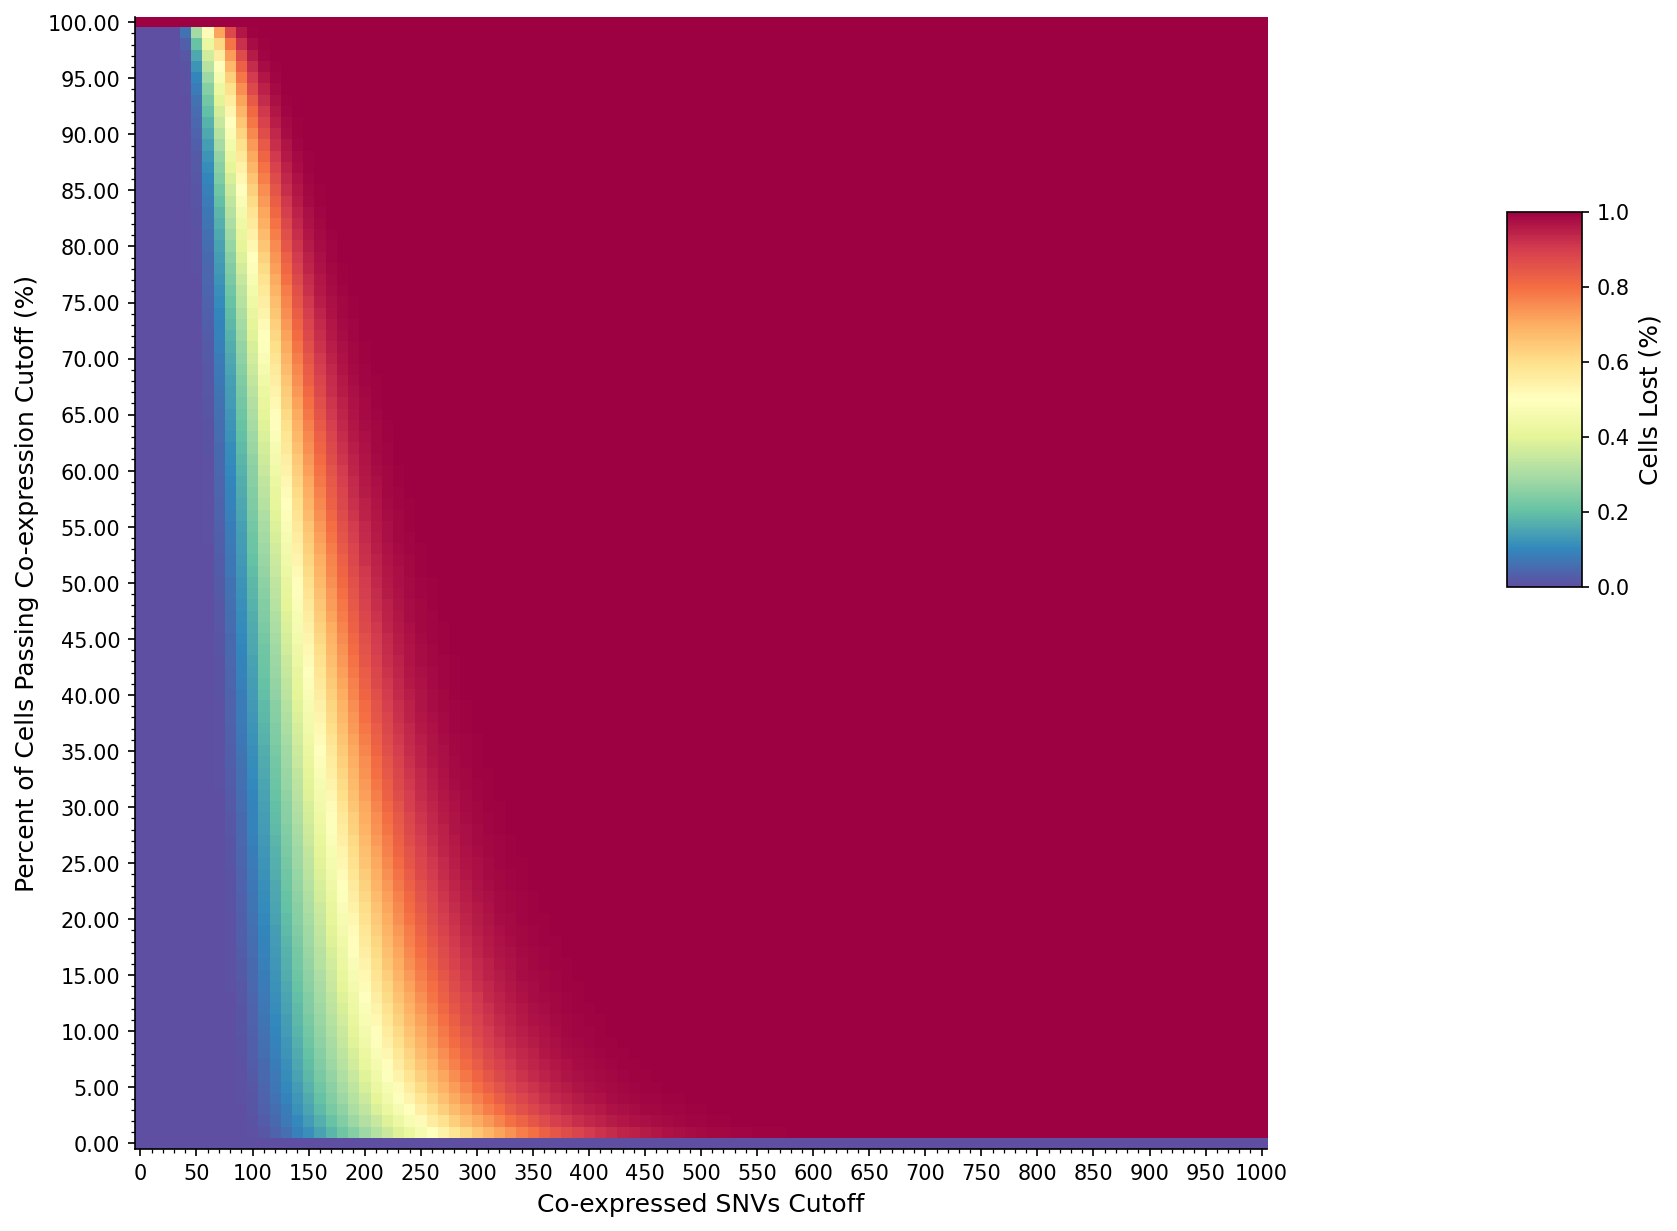

In [8]:
data.calculate_initial_distances(threads=THREADS)
data.make_qa_plot(out=None)

Passed 8,472 out of 8,472 [100.00%]
Initial Label counts: (0 = 8,472) 

Only one genoptype found try rescue_genotype to find a second one
Rescued Label counts: (0 = 7,693) (1 = 364) (3 = 415) 

Rescued a second potential genotype


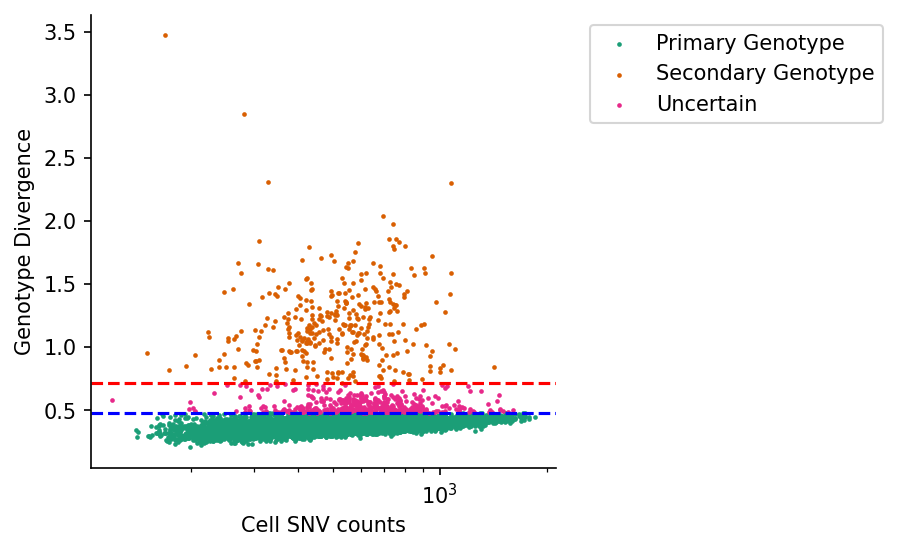

In [10]:
data.apply_cell_cutoffs(snv_cutoff=20, cell_cutoff=25)
data.cluster(k=10, threads=THREADS, resolution=0.4, seed=42, min_cells=5)
if data._NL == 1:
    data.rescue_genotype(out=None, eps=1e-5, upper_mads=10, lower_mads=3)
if data._NL == 1:
    print('cannot proceed only one genotype found')

In [11]:
refine = RT.RefineGT(snv_data.strand_ref[keep].copy(), snv_data.strand_alt[keep].copy(), snv_data.snvs[keep].copy(), snv_data.barcodes, close_fig=False)

initial:  Counter({0: 7693, 3: 415, 1: 364})
Iteration 1: number of changed labels:  354 Counter({0: 8070, 1: 337, 2: 65})
Iteration 2: number of changed labels:  26 Counter({0: 8082, 1: 327, 2: 63})
Iteration 3: number of changed labels:  13 Counter({0: 8090, 1: 322, 2: 60})
Iteration 4: number of changed labels:  1 Counter({0: 8089, 1: 322, 2: 61})


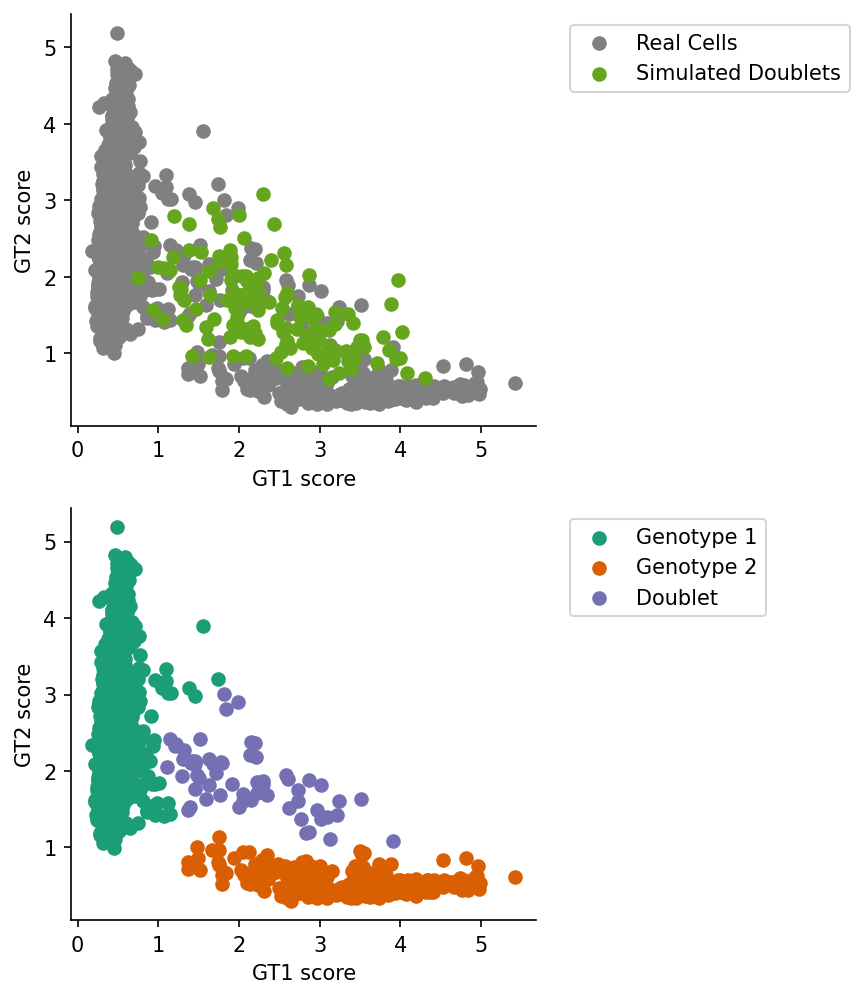

In [13]:
if not refine.refine_genotypes(data._labels['initial_clustering'], out=None):
    print('Failed to identify a second genotype')

In [21]:
df = pd.DataFrame({'barcode':refine._barcodes, 'label':refine._final_labels.copy(), 'gt1_score':refine._final_scores[:,0], 'gt2_score':refine._final_scores[:,1]})
display(df.head())
#To save to a file
df.to_csv(f'GSM4339778_SRR11182002_genotypes.csv.gz', index=0)

,barcode,label,gt1_score,gt2_score
0,GTCCTCAAGAGCTTCT,0,0.518967,3.515199
1,AGCTCCTTCACAAACC,0,0.510029,2.617624
2,GACTGCGTCTTCAACT,0,0.472478,2.648174
3,TGACTAGTCCTCAACC,0,0.464072,3.637409
4,AGTGTCACAATCAGAA,0,0.523733,3.627755


In [22]:
snvs = FindSNVs(snv_data.strand_ref[keep].copy(), snv_data.strand_alt[keep].copy(), snv_data.snvs[keep].copy(), snv_data.barcodes, df['label'].values.copy(), close_fig=False)
snvs.score_snvs()
snvs.find_predictive(5)

(5652, 8472) 1299271 5653 5652
Needed 51 SNVs to cover each singlet 5 times


In [23]:
clusters = pd.read_csv(f'GSM4339778_SRR11182002_clusters.csv')
display(clusters.head())
bmap = {b:c for b, c in zip(clusters.barcode, clusters.label)}

,barcode,label
0,GTCCTCAAGAGCTTCT,Lymphocyte
1,AGCTCCTTCACAAACC,Lymphocyte
2,GACTGCGTCTTCAACT,Lymphocyte
3,TGACTAGTCCTCAACC,Kidney
4,AGTGTCACAATCAGAA,Kidney


Using 8472 out of 8472 barcodes
[((2, 6), 61), ((1, 5), 6), ((1, 0), 15), ((1, 4), 30), ((1, 2), 271), ((0, 3), 22), ((0, 1), 78), ((0, 2), 374), ((0, 4), 397), ((0, 5), 682), ((0, 0), 6536)]
[ 5  6  7  8  9 10] [1 2 3 4]


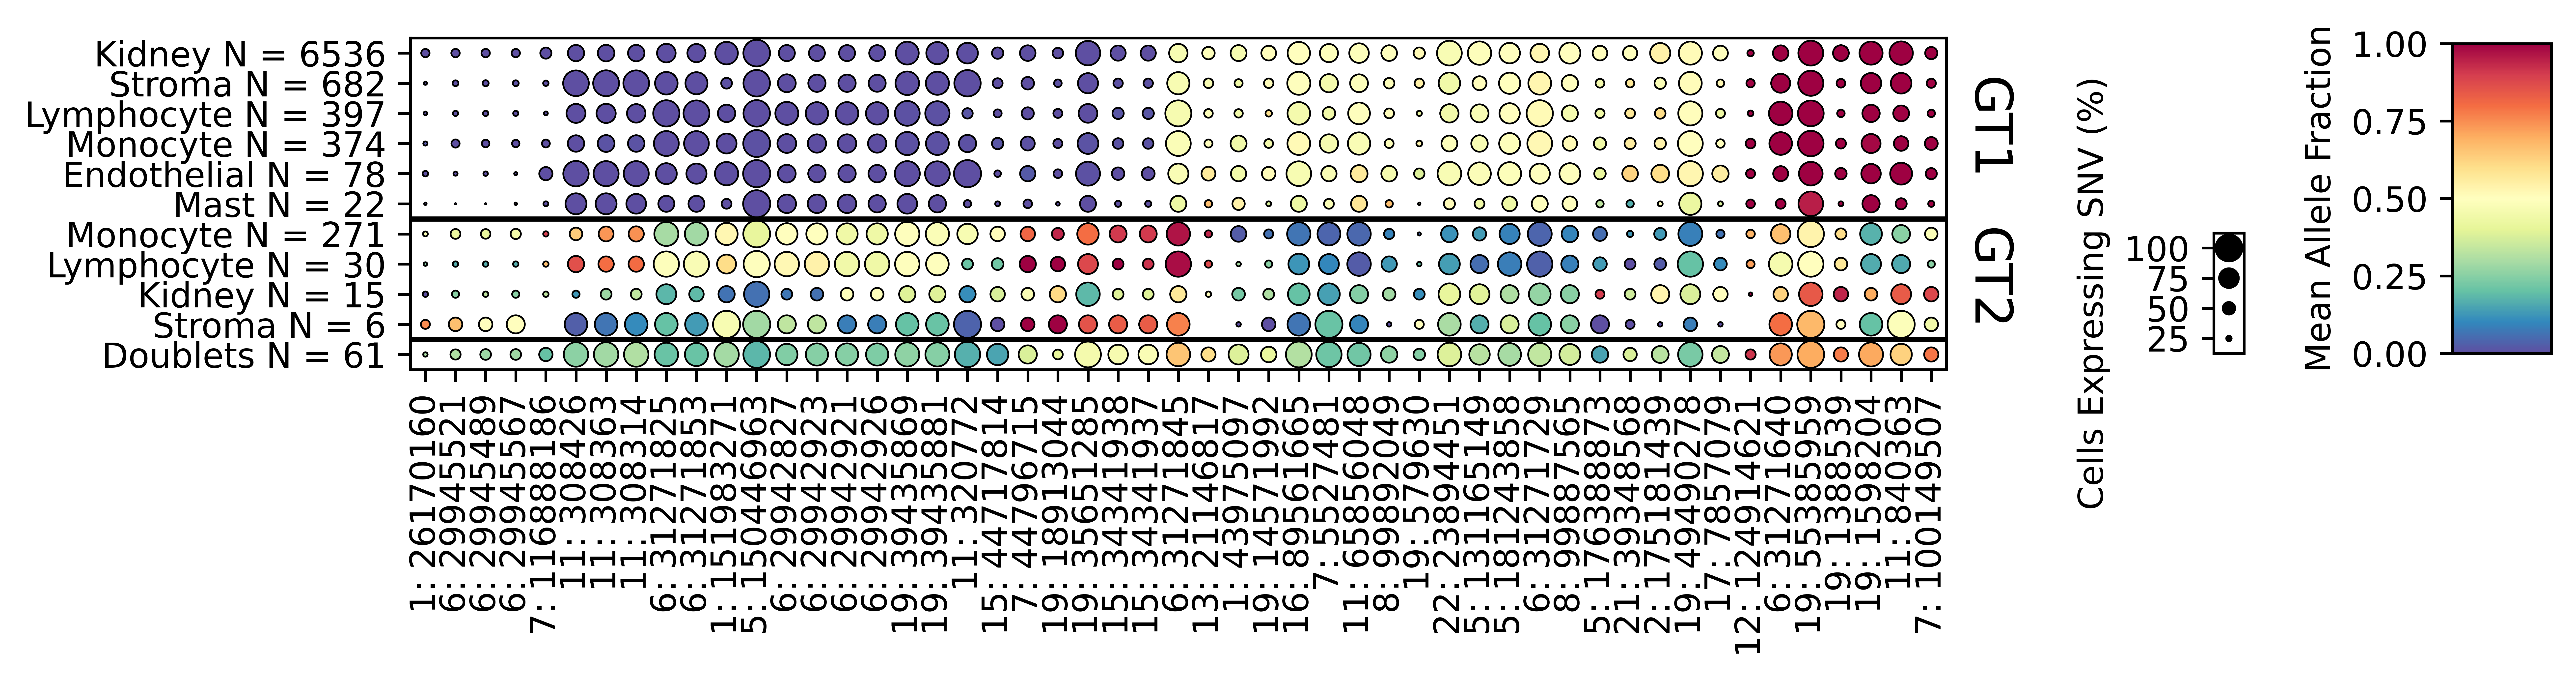

In [24]:
snvs.dotplot(bmap, out='GSM4339778_SRR11182002_dotplot.pdf')